In [ ]:
%load_ext autoreload
%autoreload 2

# **`Simple Linear Regression`**

## Part 01A

Contents:
- Polynomial model, OLS, sklearn LinearRegression, Basic Tensorflow regression

**Note**:
- Predicting probabilities can also be somewhat categorized as a regression problem (`RidgeClassifier` in sklearn)
- As we are predicting a continous bounded output between 0 and 1 (probabilities)
- It all depends on how you choose your outputs and the loss function
    - Yes, you can choose a mean squared error for loss function between predicted probabilities and the actual ground truth output. (It just won't be the maximum likelihood output)
    
    
    

In [ ]:
# Import tensorflow
import tensorflow as tf
print(tf.__version__)

In [ ]:
!nvidia-smi

## Polynomial Class

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from src.models import PolynomialModel

## Create data to view and fit

Note that features in the real world are sampled from the population in most cases That means even though we consider them as non stochastic while modelling, since we have to explain the effect of X on y, these are generally not the result of a carefully controlled experiment in which we tinker with X. Infact, the business problem defines what we choose as X and what we choose as y.


In [ ]:
xmin, xmax = -10, 40 # range
m = 1000 # no of data points
X = np.expand_dims(np.linspace(xmin, xmax, m), axis=-1) # You can randomly sample as well

# Create the labels aka the outputs (dependent variable)
polymodels = {}
polymodels['linear'] = PolynomialModel([2, 3], 5)
polymodels['quadratic'] = PolynomialModel([1, 2, -0.1], 10)

# Now sample some y
ys = {}
ys['linear'] = polymodels['linear'](X, add_noise=True)
ys['quadratic'] = polymodels['quadratic'](X, add_noise=True)


In [ ]:
X.shape, ys['linear'].shape, ys['quadratic'].shape

((1000, 1), (1000,), (1000,))

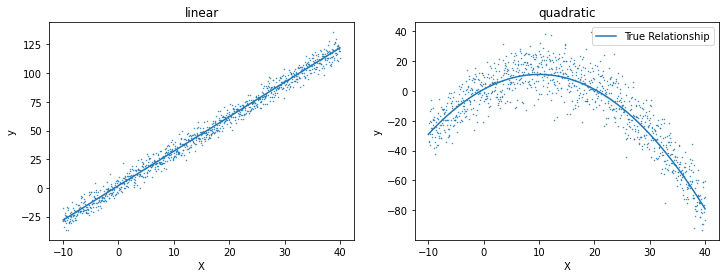

In [ ]:
# Plot!
fig, axn = plt.subplots(1, 2, figsize=(12, 4))

for ax, modtype in zip(axn, ['linear', 'quadratic']):
    
    y = ys[modtype]
    polymodel = polymodels[modtype]
    
    ax.scatter(X.flatten(), y.flatten(), s=0.2)
    polymodel.plot(X, ax=ax, label='True Relationship')
    
    ax.set_title(modtype)

    ax.set_xlabel('X')
    ax.set_ylabel('y')

plt.legend();

## OLSRegressor

In [ ]:
from src.models import OLSRegressor

#### Linear model

In [ ]:
olsmodels = {}

In [ ]:
olsmodel = OLSRegressor(add_bias=True)
olsmodel.fit(X, ys['linear'])
olsmodels['linear'] = olsmodel
olsmodel.intercept_, olsmodel.coef_

(array([1.91074421]), array([2.99237121]))

#### Quadratic model

In [ ]:
olsmodel = OLSRegressor(add_bias=True)
olsmodel.fit(np.hstack([X, X**2]), ys['quadratic'])
olsmodels['quadratic'] = olsmodel
olsmodel.intercept_, olsmodel.coef_

(array([1.6244087]), array([ 2.13019017, -0.10336479]))

## sklearn `LinearRegression` Estimate

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
linregmodels = {}

#### Linear model

In [ ]:
linregmodel = LinearRegression()
linregmodel.fit(X, y)
linregmodels['linear'] = linregmodel
linregmodel.intercept_, linregmodel.coef_

(3.3040433617052045, array([-0.97075341]))

#### Quadratic model

In [ ]:
linregmodel = LinearRegression()
linregmodel.fit(np.hstack([X, X**2]), y)
linregmodels['quadratic'] = linregmodel
linregmodel.intercept_, linregmodel.coef_

(1.624408698756513, array([ 2.13019017, -0.10336479]))

## Minimizing any function in Tensorflow

#### Minimize $y=x^2$

In [ ]:
x = tf.Variable(2.)

def f(x):
    return x*x

with tf.GradientTape() as tape:
    tape.watch(x)
    
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
xvals = []
for i in range(30):
    opt.minimize(lambda : f(x), var_list=[x])
    xvals.append(x.numpy())
    
    

In [ ]:
fvals = list(map(f, xvals))

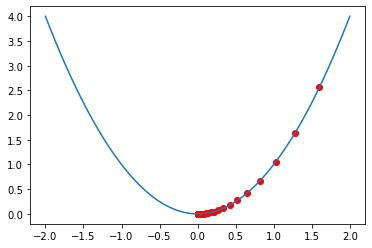

In [ ]:
pm = PolynomialModel([0, 0, 1], stderr=0) # For y = x^2
Xvals = np.expand_dims(np.linspace(-2, 2, 100), axis=-1)
ax = pm.plot(Xvals)
ax.scatter(xvals, fvals, color='red')

## Fitting Simple Linear Regression model with tensorflow

In [ ]:
# Choose linear true relationship
polymodel = polymodels['linear']
polymodel.params, polymodel.stderr

([2, 3], 5)

In [ ]:
intercept = tf.Variable(polymodel.params[0], dtype=tf.float32)
slope = tf.Variable(polymodel.params[1], dtype=tf.float32)

def predict(intercept, slope, X):
    m = PolynomialModel([intercept, slope], stderr=0)
    return m(X)

def mse(labels, preds):
    return tf.keras.losses.mse(labels, preds)
    
def loss_func(intercept, slope, X, y):
    predictions = predict(intercept, slope, X)
    return mse(y, predictions)

with tf.GradientTape() as tape:
    tape.watch(intercept)
    tape.watch(slope)
    
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
for i in range(20):
    opt.minimize(lambda : loss_func(intercept, slope, X, y), var_list=[intercept, slope])

ValueError: No gradients provided for any variable: ['Variable:0', 'Variable:0'].